In [11]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [12]:
import learning_contracting_polynomials
import polynomial_tools
import os, re
import sympy
from sympy.utilities import lambdify
from sympy import octave_code
import constraint_maker
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from importlib import reload
from scipy.integrate import odeint

%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [15]:
# visualize_vf
def visualize_vf(f, limits=[-.1, .1, -.1, .1]):
    nx, ny = 100, 100
    xx = np.linspace(*limits[:2], nx)
    yy = np.linspace(*limits[2:], ny)
    X, Y = np.meshgrid(xx, yy)
    XY = [X.flatten(), Y.flatten()]
    fXY = np.array([f(xy) for xy in zip(*XY)])
    Ex, Ey = fXY[:, 0], fXY[:, 1]
    Ex, Ey = Ex.reshape(nx, ny), Ey.reshape(nx, ny)
    plt.streamplot(xx, yy, Ex, Ey,linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
    plt.xlim(limits[:2])
    plt.ylim(limits[2:])



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 215             
  Cones                  : 0               
  Scalar variables       : 115             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 215             
  Cones                  : 0               
  Scalar variables       : 115             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 28              
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 15
Optimizer  - Cones                  : 0
Optimizer  - Scalar variables     

array([[ 1.93963825e-02,  5.84845830e-02, -7.97581697e-01,
         1.18784647e+00,  3.81474168e-11, -6.34598214e-01,
         1.82870153e-01],
       [ 1.44490161e-02, -4.13791418e-03,  3.85723077e-01,
        -1.64900702e+00,  1.65968002e+00,  5.55277350e-11,
        -4.25587596e-01]])

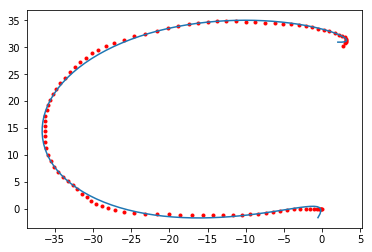

In [22]:
# Load and fit data
def load_data_from_file(data_file):
    data = sio.loadmat(data_file)
    demos = data['demos'][0]

    x, t, x_dot, x_acc, dt  = map(lambda u: u, demos[0][0][0])
    t = t[0]
    t /= t[-1]
    # normalize
    #t = np.linspace(0, 1, len(t))
    x = x
    return t, x

t, real_path = load_data_from_file('lasa_dataset/CShape.mat')
step = 10
t = t[::step]
real_path = real_path[:, ::step]

scale = 1000.
translation = np.mean(real_path, axis=1)

deg_p = 6
poly_fit_fct = polynomial_tools.fit_polynomial_with_regularization
p_scaled = np.array([poly_fit_fct(t, xi, deg=deg_p, alpha=1e-3) 
              for xi in (real_path-translation[:, None])/scale])

p_as_func_scaled = lambda t: np.array(list(map(lambda pi: polynomial_tools.eval_poly_from_coefficients(pi, t),
                               p_scaled)))
p_as_func = lambda t: translation[:, None] + scale * p_as_func_scaled(t)
                               
poly_path = p_as_func(t)

plt.scatter(*real_path, marker='.', color='r')
plt.plot(*poly_path)

p_scaled

In [25]:
reload(learning_contracting_polynomials)
reload(constraint_maker)

learning_fct = learning_contracting_polynomials.learn_polynomial_vf_with_contraction
params = {
    "deg": 8,
    "tau": .1,
    "alpha": 1e-6,
    "make_zero_at_end_demo": True,
    "verbose": False}
logger.setLevel(logging.INFO)
opt_value, opt_scaled_vf = learning_fct(p_scaled, **params)

INFO:root:degree of p(t) = 6, degree of f(x) = 8, dim = 2, tau = 0.1.
INFO:root:Creating symbolic variables
INFO:root:Compute the jacobian of f(x).
INFO:root:Compute f(p(t)), Jf(p(t)) and f(p(t)) - pdot(t).
INFO:root:Declare f(p(1))
INFO:root:Declare X_error = [[s error^T], [error sI]].
INFO:root:Declare X_contraction = -Jf - Jf.T - tau * I.
INFO:root:End of symbolic declarations,converting from sympy polynomials to arrays of coefficient.
INFO:root:Creating cvx vars for f(x) and s(t).
INFO:root:Converting sympy expressions to cvxpy.
INFO:root:Declare constraints
INFO:root:Making X(t) psd requires matrice Q1 and Q2 of size 44, 42 resp.
INFO:root:Making X(t) psd requires matrice Q1 and Q2 of size 75, 72 resp.
INFO:root:Declare objective = int_0^1 s(t) dt + alpha*norm(f).
INFO:root:Solving...
INFO:root:Problem status is optimal, tracking error is 0.05.Converting f back to sympy.
INFO:root:Done.


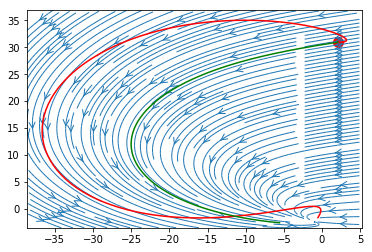

In [26]:
sym_x = sympy.symbols('x_0:%d' % real_path.shape[0])

scaled_vector_field_f = lambdify(sym_x, opt_scaled_vf)
scale_vector = lambda x: (np.array(x)-translation)/scale
vector_field_f = lambda x: scale * np.array(scaled_vector_field_f(*scale_vector(x)))
vector_field_f_t = lambda x, t: vector_field_f(x)

x_initial = poly_path[:, 0]
vf_path = odeint(vector_field_f_t, x_initial, np.linspace(0, 1., 1000), )
plt.plot(*poly_path, color='r')
#plt.plot(*real_path, color='r')
limits = plt.xlim() + plt.ylim()
plt.plot(*vf_path.T, color='g')
plt.scatter(*x_initial, s=100, color='r')
visualize_vf(vector_field_f, limits)
